<a href="https://colab.research.google.com/github/110805/EEG_classification/blob/master/DeepConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/110805/EEG_classification.git
%cd EEG_classification/

Cloning into 'EEG_classification'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 30 (delta 12), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.
/content/EEG_classification


(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
Train epoch 300 Accuracy: 92.78%
Test epoch 300 Accuracy: 72.59%

Train epoch 300 Accuracy: 91.30%
Test epoch 300 Accuracy: 73.15%

Train epoch 300 Accuracy: 94.26%
Test epoch 300 Accuracy: 77.31%



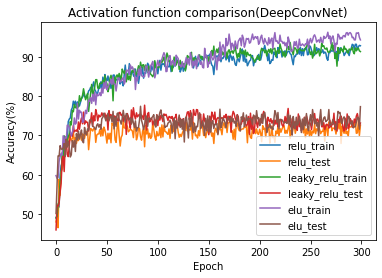

In [3]:
import dataloader 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Hyperparameter setting
batch_size = 64
learning_rate = 0.01
epochs = 300
momentum = 0.9

# Loading data
train_data, train_label, test_data, test_label = dataloader.read_bci_data()
train_data = torch.from_numpy(train_data)
train_label = torch.from_numpy(train_label)
test_data = torch.from_numpy(test_data)
test_label = torch.from_numpy(test_label)
train_loader = DataLoader(TensorDataset(train_data, train_label), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_data, test_label), batch_size= batch_size)

class DeepConvNet(nn.Module):
    def __init__(self, activation):
        super(DeepConvNet, self).__init__()
        if activation == 'relu':
            self.activate = nn.ReLU()
        elif activation == 'leaky':
            self.activate = nn.LeakyReLU()
        else:
            self.activate = nn.ELU()

        self.C = 2
        self.T = 750
        self.N = 2

        self.conv1 = nn.Conv2d(1, 25, kernel_size=(1,5))
        self.conv2 = nn.Conv2d(25, 25, kernel_size=(self.C,1))
        self.batchnorm1 = nn.BatchNorm2d(25, eps=1e-05, momentum=0.1)
        self.maxpool = nn.MaxPool2d(kernel_size=(1,2))
        self.conv3 = nn.Conv2d(25, 50, kernel_size=(1,5))
        self.batchnorm2 = nn.BatchNorm2d(50, eps=1e-05, momentum=0.1)
        self.conv4 = nn.Conv2d(50, 100, kernel_size=(1,5))
        self.batchnorm3 = nn.BatchNorm2d(100, eps=1e-05, momentum=0.1)
        self.conv5 = nn.Conv2d(100, 200, kernel_size=(1,5))
        self.batchnorm4 = nn.BatchNorm2d(200, eps=1e-05, momentum=0.1)
        self.linear = nn.Linear(8600, self.N)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.activate(self.batchnorm1(out))
        out = F.dropout(self.maxpool(out), p=0.5)
        out = self.conv3(out)
        out = self.activate(self.batchnorm2(out))
        out = F.dropout(self.maxpool(out), p=0.5)
        out = self.conv4(out)
        out = self.activate(self.batchnorm3(out))
        out = F.dropout(self.maxpool(out))
        out = self.conv5(out)
        out = self.activate(self.batchnorm4(out))
        out = F.dropout(self.maxpool(out), p=0.5)
        out = out.view(-1, 8600) # flatten
        out = self.linear(out) # dense layer

        return out

models = [DeepConvNet(activation='relu'), DeepConvNet(activation='leaky'), DeepConvNet(activation='elu')]
Loss = nn.CrossEntropyLoss()

def train(epoch, model):
    model.train() # switch to train mode
    correct = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch.float())
        loss = Loss(y_pred, y_batch.long())
        loss.backward()
        optimizer.step()
        pred = torch.argmax(y_pred, dim=1)
        correct += torch.sum(pred == y_batch.int())

    if (epoch+1) == epochs:
        print('Train epoch {} Accuracy: {:.2f}%'.format(epoch+1, 100*correct.item()/len(train_label)))

    return 100*correct.item()/len(test_label)

def test(epoch, model):
    model.eval()
    correct = 0
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            y_pred = model(x_batch.float())
        
        pred = torch.argmax(y_pred, dim=1)
        correct += torch.sum(pred == y_batch.int())
    
    if (epoch+1) == epochs:
        print('Test epoch {} Accuracy: {:.2f}%'.format(epoch+1, 100*correct.item()/len(test_label)))

    return 100*correct.item()/len(test_label)

device = torch.device('cuda')
legend = ['relu_train', 'relu_test', 'leaky_relu_train', 'leaky_relu_test', 'elu_train', 'elu_test']
for i, model in enumerate(models):
    model.to(device)
    train_acc = []
    test_acc = []
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=5e-4)
    for epoch in range(epochs):
        train_acc.append(train(epoch, model))
        test_acc.append(test(epoch, model))
        #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
    
    print()
    plt.plot(range(epochs), train_acc, label=legend[2*i])
    plt.plot(range(epochs), test_acc, label=legend[2*i+1])

plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.title("Activation function comparison(DeepConvNet)")
plt.legend(loc='best')
plt.savefig("Result_DeepConvNet.png")
plt.show()